In [2]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

In [3]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [4]:
# reminder: image is downscaled by 3, we need to downscale the label coordinates as well
scale = 3

In [124]:
# location of silicon wafer 1 data
dir_silicon_wafer_1 = "../dataset/section-segmentation-dataset/silicon_wafer_1"

In [125]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

In [126]:
#wafer_tissue_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_tissue_reduced.txt", sep="\t|,", header=None, names=index, engine='python')//scale
wafer_tissue_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_tissue.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
print(f"Size of the Silicon Wafer 1 dataset, tissue part is {wafer_tissue_lbl.shape}")
wafer_tissue_lbl.head()

Size of the Silicon Wafer 1 dataset, tissue part is (514, 8)


point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    6785  3094    6724  2937    7103  2812    7120  2965
1    6347  3218    6275  3066    6649  2922    6675  3071
2    6037  3596    5972  3442    6352  3314    6371  3463
3    6487  3605    6399  3461    6749  3274    6793  3424
4    6858  3507    6776  3363    7136  3187    7170  3333

In [127]:
#wafer_magnet_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_mag_reduced.txt", sep="\t|,", header=None, names=index, engine='python')//scale
# Without scale
wafer_magnet_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_mag.txt", sep="\t|,", header=None, names=index, engine='python')
print(f"Size of the Silicon Wafer 1 dataset, magnet part is {wafer_magnet_lbl.shape}")
wafer_magnet_lbl.head()

Size of the Silicon Wafer 1 dataset, magnet part is (514, 8)


point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    6840  3232    6787  3099    7120  2968    7143  3117
1    6410  3355    6351  3225    6672  3075    6707  3217
2    6096  3733    6041  3599    6372  3467    6396  3610
3    6566  3739    6490  3609    6791  3425    6842  3564
4    6930  3636    6859  3510    7171  3336    7212  3479

In [130]:
f= open("new_boxes.txt","w+")
for i in range(wafer_magnet_lbl.shape[0]):
    temp_mag = wafer_magnet_lbl.iloc[i]
    max_x_mag = max(temp_mag['point_1']['x'], temp_mag['point_2']['x'], temp_mag['point_3']['x'], temp_mag['point_4']['x'])
    min_x_mag = min(temp_mag['point_1']['x'], temp_mag['point_2']['x'], temp_mag['point_3']['x'], temp_mag['point_4']['x'])
    max_y_mag = max(temp_mag['point_1']['y'], temp_mag['point_2']['y'], temp_mag['point_3']['y'], temp_mag['point_4']['y'])
    min_y_mag = min(temp_mag['point_1']['y'], temp_mag['point_2']['y'], temp_mag['point_3']['y'], temp_mag['point_4']['y'])
    
    temp_tissue = wafer_tissue_lbl.iloc[i]
    margin = 50
    max_x = max(max_x_mag,temp_tissue['point_1']['x'], temp_tissue['point_2']['x'], temp_tissue['point_3']['x'], temp_tissue['point_4']['x']) + margin
    min_x = min(min_x_mag,temp_tissue['point_1']['x'], temp_tissue['point_2']['x'], temp_tissue['point_3']['x'], temp_tissue['point_4']['x']) - margin
    max_y = max(max_y_mag,temp_tissue['point_1']['y'], temp_tissue['point_2']['y'], temp_tissue['point_3']['y'], temp_tissue['point_4']['y']) + margin
    min_y = min(min_y_mag,temp_tissue['point_1']['y'], temp_tissue['point_2']['y'], temp_tissue['point_3']['y'], temp_tissue['point_4']['y']) - margin
    
    
    
    f.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (min_x, min_y,  max_x,min_y,  max_x,max_y,  min_x,max_y))

f.close() 

In [131]:
boxes = pd.read_csv(f"new_boxes.txt", sep="\t|,", header=None, names=index, engine='python')//3
#Without scale
boxes.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    2224   920    2397   920    2397  1094    2224  1094
1    2075   957    2252   957    2252  1135    2075  1135
2    1974  1088    2148  1088    2148  1261    1974  1261
3    2116  1074    2297  1074    2297  1263    2116  1263
4    2242  1045    2420  1045    2420  1228    2242  1228

### Drawing

In [11]:
def rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [12]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)
    
    return image

In [132]:
path_img= f"{dir_silicon_wafer_1}/wafer_1_downsized_3.tif"

In [133]:
if os.path.isfile(path_img):
    wafer_1_boxes = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

In [134]:
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

In [135]:
wafer_1_boxes = draw_labels(wafer_1_boxes, boxes, thickness, magnet_color, fill_poly)

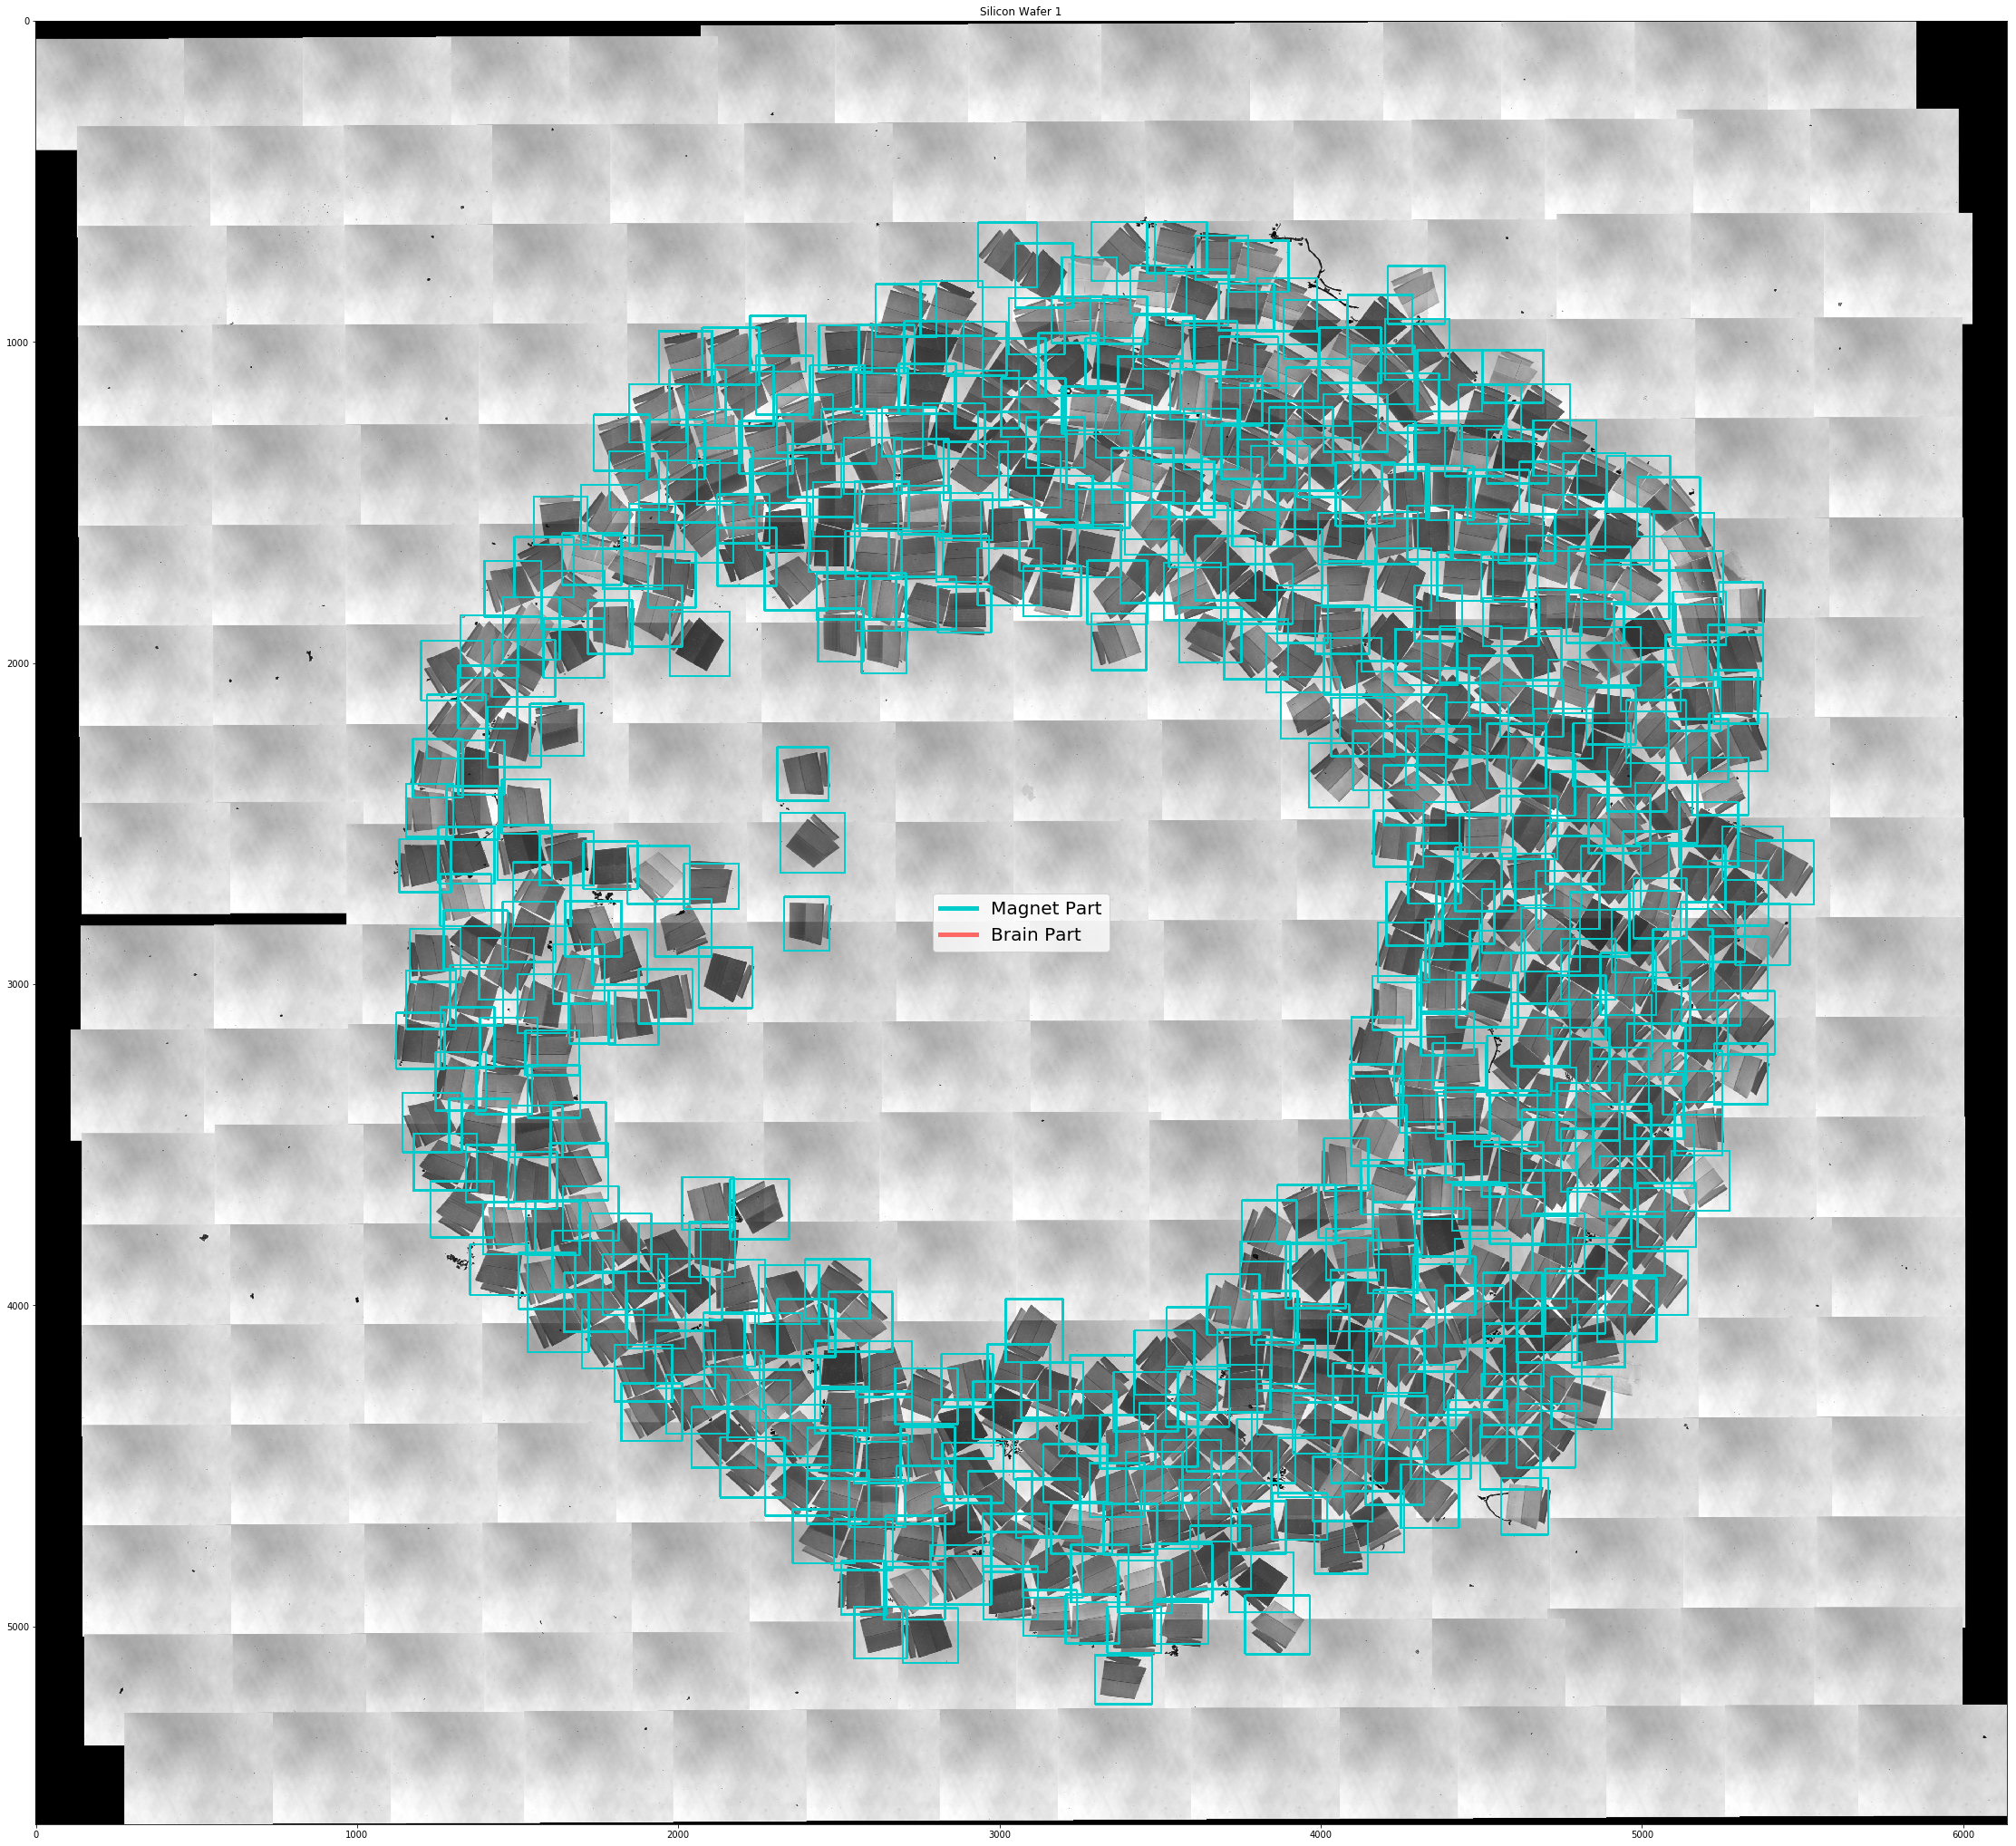

In [136]:
plt.figure(figsize=(40, 36.61))
plt.imshow(wafer_1_boxes)

plt.title('Silicon Wafer 1')

legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                   Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]
plt.legend(handles=legend_elements, loc='center', fontsize=20)

plt.show()

In [183]:
wafer_tissue_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_tissue.txt", sep="\t|,", header=None, names=index, engine='python')//3

In [184]:
wafer_mag_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_mag.txt", sep="\t|,", header=None, names=index, engine='python')//3

In [185]:
if os.path.isfile(path_img):
    wafer_1 = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

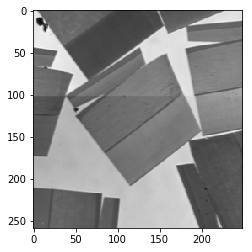

In [186]:
f_seg_tissues= open("boxes_tissues.txt","w+")
f_seg_mag= open("boxes_mag.txt","w+")
f_boxes= open("new_boxes.txt","w+")
for i in range(wafer_mag_lbl.shape[0]):
    
    margin = 50
    
    temp_mag = wafer_mag_lbl.iloc[i]
    max_x_mag = max(temp_mag['point_1']['x'], temp_mag['point_2']['x'], temp_mag['point_3']['x'], temp_mag['point_4']['x'])
    min_x_mag = min(temp_mag['point_1']['x'], temp_mag['point_2']['x'], temp_mag['point_3']['x'], temp_mag['point_4']['x'])
    max_y_mag = max(temp_mag['point_1']['y'], temp_mag['point_2']['y'], temp_mag['point_3']['y'], temp_mag['point_4']['y'])
    min_y_mag = min(temp_mag['point_1']['y'], temp_mag['point_2']['y'], temp_mag['point_3']['y'], temp_mag['point_4']['y'])
    
    temp_tissue = wafer_tissue_lbl.iloc[i]

    max_x = max(max_x_mag,temp_tissue['point_1']['x'], temp_tissue['point_2']['x'], temp_tissue['point_3']['x'], temp_tissue['point_4']['x']) + margin 
    min_x = min(min_x_mag,temp_tissue['point_1']['x'], temp_tissue['point_2']['x'], temp_tissue['point_3']['x'], temp_tissue['point_4']['x']) - margin 
    max_y = max(max_y_mag,temp_tissue['point_1']['y'], temp_tissue['point_2']['y'], temp_tissue['point_3']['y'], temp_tissue['point_4']['y']) + margin 
    min_y = min(min_y_mag,temp_tissue['point_1']['y'], temp_tissue['point_2']['y'], temp_tissue['point_3']['y'], temp_tissue['point_4']['y']) - margin
    
    crop_tissues_p1_x = temp_tissue['point_1']['x'] - min_x  + margin//3
    crop_tissues_p1_y = temp_tissue['point_1']['y'] - min_y  + margin//3
    
    crop_tissues_p2_x = temp_tissue['point_2']['x'] - min_x  + margin//3
    crop_tissues_p2_y = temp_tissue['point_2']['y'] - min_y  + margin//3
    
    crop_tissues_p3_x = temp_tissue['point_3']['x'] - min_x  + margin//3
    crop_tissues_p3_y = temp_tissue['point_3']['y'] - min_y + margin//3
    
    crop_tissues_p4_x = temp_tissue['point_4']['x'] - min_x + margin//3
    crop_tissues_p4_y = temp_tissue['point_4']['y'] - min_y + margin//3
    
    crop_mag_p1_x = temp_mag['point_1']['x'] - min_x  + margin//3
    crop_mag_p1_y = temp_mag['point_1']['y'] - min_y  + margin//3
    
    crop_mag_p2_x = temp_mag['point_2']['x'] - min_x  + margin//3
    crop_mag_p2_y = temp_mag['point_2']['y'] - min_y  + margin//3
    
    crop_mag_p3_x = temp_mag['point_3']['x'] - min_x  + margin//3
    crop_mag_p3_y = temp_mag['point_3']['y'] - min_y + margin//3
    
    crop_mag_p4_x = temp_mag['point_4']['x'] - min_x + margin//3
    crop_mag_p4_y = temp_mag['point_4']['y'] - min_y + margin//3
    
    f_seg_tissues.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (crop_tissues_p1_x,crop_tissues_p1_y,  crop_tissues_p2_x,crop_tissues_p2_y,  crop_tissues_p3_x,crop_tissues_p3_y,  crop_tissues_p4_x,crop_tissues_p4_y))
    f_seg_mag.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (crop_mag_p1_x,crop_mag_p1_y,  crop_mag_p2_x,crop_mag_p2_y,  crop_mag_p3_x,crop_mag_p3_y,  crop_mag_p4_x,crop_mag_p4_y))
    f_boxes.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (min_x, min_y,  max_x,min_y,  max_x,max_y,  min_x,max_y))
    
    crop_img = wafer_1[min_y:max_y, min_x:max_x]
    plt.imshow(crop_img)
    cv.imwrite("data1_cropped/"+str(i)+".tiff", crop_img)
f.close() 

In [170]:
boxes_tissues = pd.read_csv(f"boxes_tissues.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_tissues.head()

point_1      point_2     point_3     point_4    
        x    y       x   y       x   y       x   y
0      36  110      16  58     142  16     148  67
1      40  114      16  64     141  16     150  65
2      38  110      16  59     143  16     149  66
3      45  126      16  78     132  16     147  66
4      44  123      16  75     136  16     148  65

In [171]:
boxes_mag = pd.read_csv(f"boxes_mag.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_mag.head()

point_1      point_2      point_3     point_4     
        x    y       x    y       x   y       x    y
0      55  156      37  112     148  68     156  118
1      61  160      42  117     149  67     160  114
2      58  156      39  111     150  67     158  115
3      71  171      46  128     146  66     163  113
4      68  166      44  124     148  66     162  113

In [172]:
seg_tissue = boxes_tissues[0:1]
seg_tissue

point_1      point_2     point_3     point_4    
        x    y       x   y       x   y       x   y
0      36  110      16  58     142  16     148  67

In [173]:
seg_mag = boxes_mag[0:1]
seg_mag

point_1      point_2      point_3     point_4     
        x    y       x    y       x   y       x    y
0      55  156      37  112     148  68     156  118

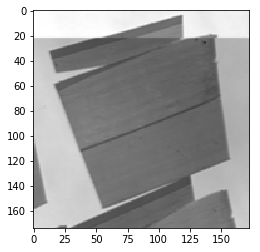

In [179]:
if os.path.isfile(path_img):
    wafer_1 = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

crop_img = wafer_1[boxes.iloc[0]['point_1']['y']:boxes.iloc[0]['point_3']['y'], boxes.iloc[0]['point_1']['x']:boxes.iloc[0]['point_3']['x']]
plt.imshow(crop_img)

In [181]:
cv.imwrite("test.tiff", crop_img)

True

In [174]:
crop_img = draw_labels(crop_img, seg_tissue, 2, magnet_color, fill_poly)
crop_img = draw_labels(crop_img, seg_mag, 2, tissue_color, fill_poly)

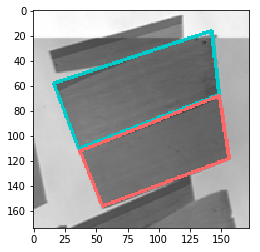

In [175]:
plt.imshow(crop_img)